# Семинар 15 - Гауссова регрессия

  1. Напишем GP с цилиндрическим ядром
  2. Посмотрим на нестационарные ядра
  3. Запустим KISS GP
  4. Обучим нейронку

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='Mean of GP')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

## Ядра

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$
### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [2]:
class GaussianKernel:
    def __init__(self, sigma: float):
        self.sigma = sigma
        
    def __call__(self, x1, x2):
        # l2-норма между матрицами x_train[N, K] y_train[M, K]
        # Выходом должна быть матрица [N, M]
        dist = (np.sum(x1**2, 1)[:, None] + 
                np.sum(x2**2, 1)[None, :] - 
                2 * x1.dot(x2.T)) 
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

## Matern kernel

$$K\left(x, x^{\prime}\right)=\frac{\sigma_{f}^{2} 2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2 \nu}\|x-x^{\prime}\|}{\rho}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu}\|x-x^{\prime}\|}{\rho}\right)$$

Для $$\nu=1 / 2: K\left(x, x^{\prime}\right)=\sigma_{f}^{2} \exp \left(-\|x-x^{\prime}\| / \rho\right)$$

In [3]:
from scipy.special import kv
from scipy.special import gamma
import math

class MaternKernel:
    def __init__(self, nu, rho):
        self.nu = nu
        self.rho = rho
    
    def __call__(self, x1, x2):
        x1 = x1 / self.rho
        x2 = x2 / self.rho
        dists = (
            np.sum(x1**2, 1)[:, None] + 
            np.sum(x2**2, 1)[None, :] - 
            2 * x1.dot(x2.T)
        )
        
        if self.nu == 0.5:
            K = np.exp(-dists)
        elif self.nu == 1.5:
            K = dists * math.sqrt(3)
            K = (1. + K) * np.exp(-K)
        elif self.nu == 2.5:
            K = dists * math.sqrt(5)
            K = (1. + K + K ** 2 / 3.0) * np.exp(-K)
        else:
            K = dists
            K[K == 0.0] += np.finfo(float).eps 
            tmp = (math.sqrt(2 * self.nu) * K)
            K.fill((2 ** (1. - self.nu)) / gamma(self.nu))
            K *= tmp ** self.nu
            K *= kv(self.nu, tmp)
        return np.nan_to_num(K)

## [Cylindrical Kernels from ICML2018](https://icml.cc/Conferences/2018/ScheduleMultitrack?event=2230):

$$\begin{array}{ll}{T(\mathbf{x})=\left\{\begin{array}{ll}{\left(\|\mathbf{x}\|_{2}, \mathbf{x} /\|\mathbf{x}\|_{2}\right)} & {\text { for }\|\mathbf{x}\|_{2} \neq 0} \\ {\left(0, \mathbf{a}_{a r b i t r a r y}\right)} & {\text { for }\|\mathbf{x}\|_{2}=0}\end{array}\right.} \\ {T^{-1}(r, \mathbf{a})=r \mathbf{a}}\end{array}$$

$$\begin{aligned} K_{c y l}\left(\mathbf{x}_{1}, \mathbf{x}_{2}\right) &=\widetilde{K}\left(T\left(\mathbf{x}_{1}\right), T\left(\mathbf{x}_{2}\right)\right) \\ &=K_{r}\left(r_{1}, r_{2}\right) \cdot K_{a}\left(\mathbf{a}_{1}, \mathbf{a}_{2}\right) \end{aligned}$$

In [4]:
class CylindricalKernel:
    def __init__(self, angular_weights, radial_base_kernel, alpha=1., beta=1., eps=1e-9):
        self.angular_weights = angular_weights
        self.radial_base_kernel = radial_base_kernel
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    
    def __call__(self, x1, x2):
        x1 = x1.copy()
        x1[x1 == 0] = x1[x1 == 0] + self.eps
        r1 = np.linalg.norm(x1, axis=1, keepdims=True)
        
        x2 = x2.copy()
        x2[x2 == 0] = x2[x2 == 0] + self.eps
        r2 = np.linalg.norm(x2, axis=1, keepdims=True)

        if np.any(r1 > 1.0) or np.any(r2 > 1.0):
            raise RuntimeError("Cylindrical kernel not defined for data points with radius > 1. Scale your data!")

        a1, a2 = x1 / r1, x2 / r2
        
        dist = a1.dot(a2.T)
        angular_kernel = np.zeros_like(dist)
        for p in range(len(self.angular_weights)):
            angular_kernel += (dist**p) * self.angular_weights[p]
        
        radial_kernel = self.radial_base_kernel(self.kuma(r1), self.kuma(r2))
        
        return radial_kernel * angular_kernel

    def kuma(self, x):
        res = 1 - (1 - x**(self.alpha) + self.eps)**(self.beta)
        return res

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$. А ещё мы выбрали некоторое ядро $\mathrm{kern}(\cdot, \cdot)$.

Тогда гауссова регрессия(гауссов процесс) записывается следующим образом:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Т.е. матрица ковариаций это матрица ядра. Как мы увидим дальше, выбор ядра __очень важен__ и зависит от задачи.

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

In [5]:
# Noiseless training data
X_train = np.linspace(-5, 1, 40).reshape(-1, 1)
y_train = np.sin(2 * X_train) + X_train / 2 # + np.random.randn(*X_train.shape) / 2 + 

In [6]:
N = 1000
X_test = np.linspace(-8, 8, N).reshape(-1, 1)

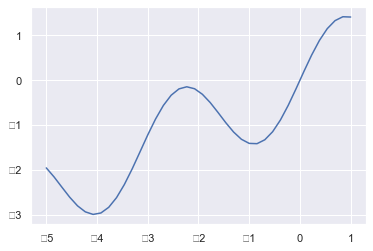

In [7]:
plt.plot(X_train[:, 0], y_train.ravel())

### Какое сейчас время? Время Гауссовой Регрессии!

In [8]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        # copy-paste code above
        
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

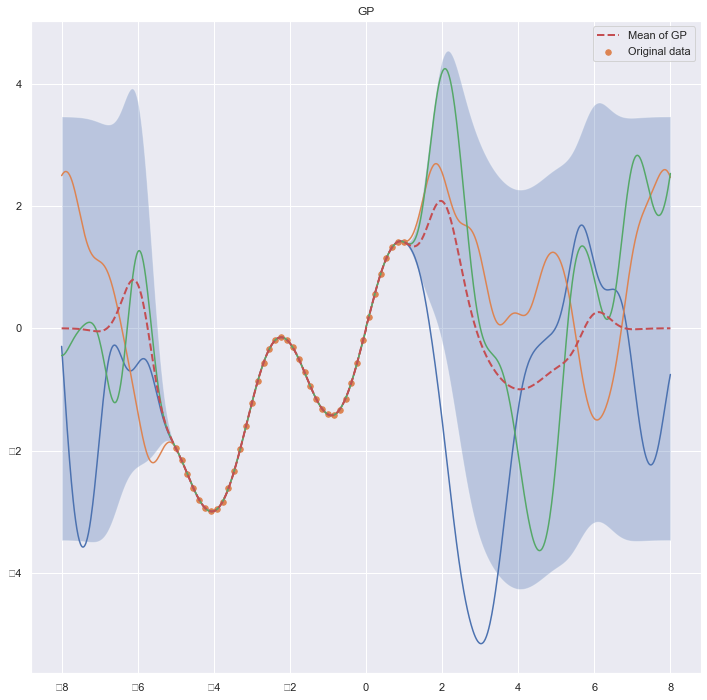

In [9]:
kernel = CylindricalKernel(angular_weights=np.array([1., 1., 1.]), radial_base_kernel=MaternKernel(nu=5/2, rho=0.1))
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-5)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12, n=3).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

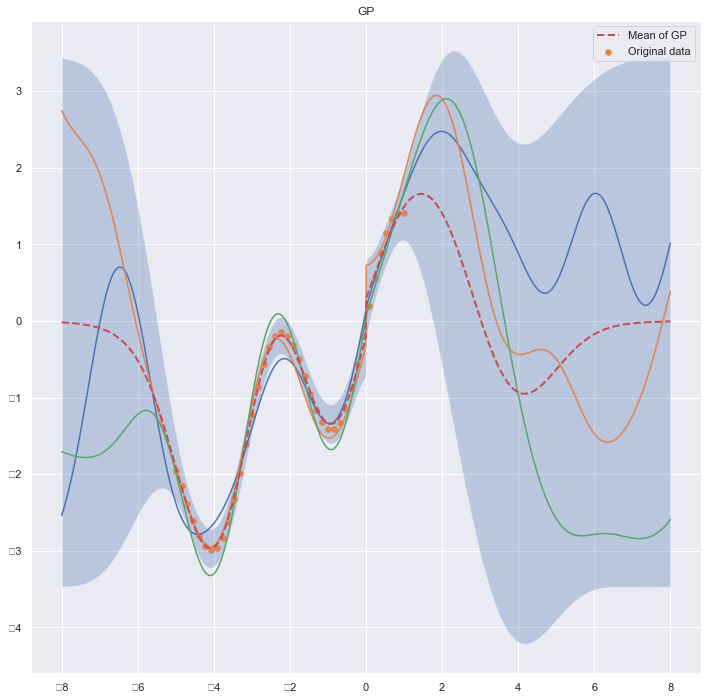

In [10]:
kernel = CylindricalKernel(angular_weights=np.ones(3), radial_base_kernel=GaussianKernel(sigma=0.1))
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-1)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12, n=3).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

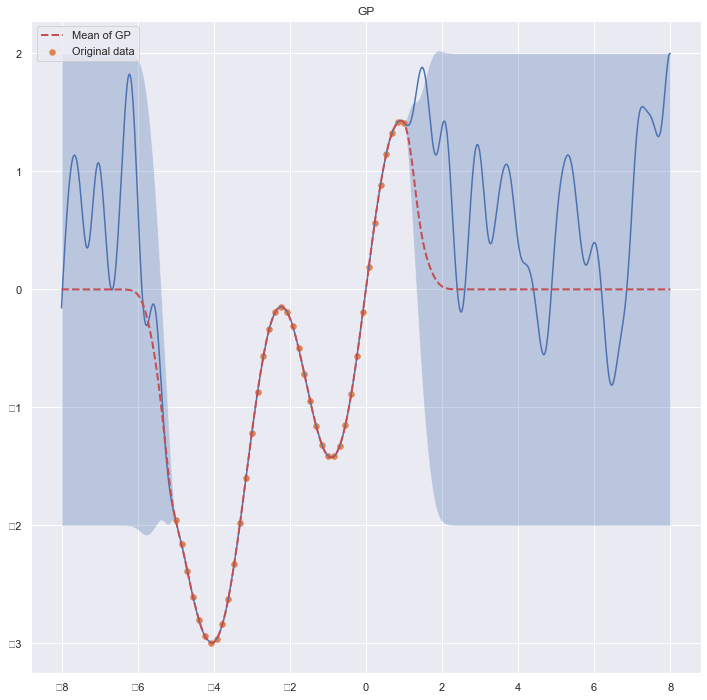

In [14]:
kernel = MaternKernel(nu=5/2, rho=0.05)
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-5)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

## GPy with some real data

In [15]:
import GPy

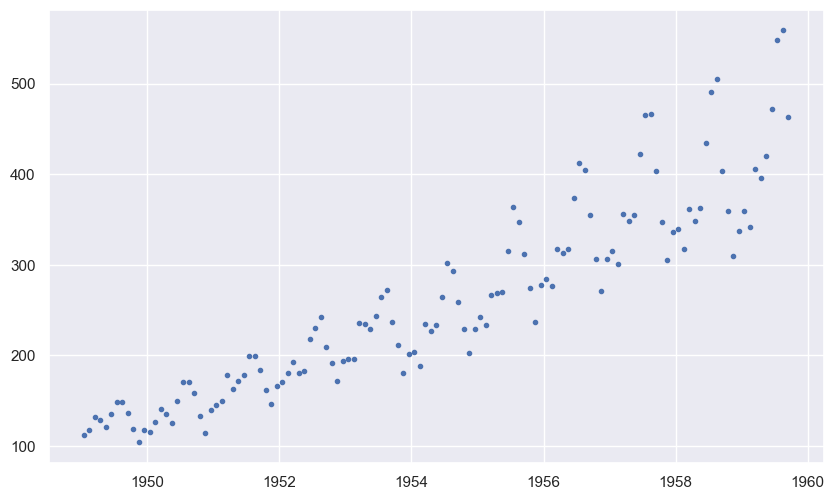

In [119]:
from scipy.io import loadmat

data = loadmat('airline.mat')

X = data['X']
y = data['y']

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(X, y, '.')

In [120]:
k_rbf_1 = GPy.kern.Linear(1)
k_rbf_2 = GPy.kern.RBF(1)

{'covariance': [[<matplotlib.lines.Line2D at 0x7fb31158b820>]]}

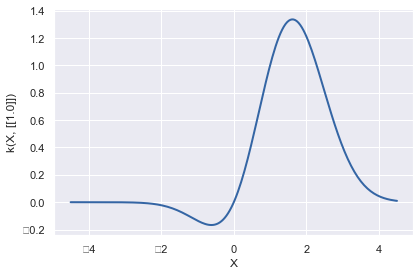

In [121]:
(k_rbf_1 * k_rbf_2).plot()

{'covariance': [[<matplotlib.lines.Line2D at 0x7fb311a15c70>]]}

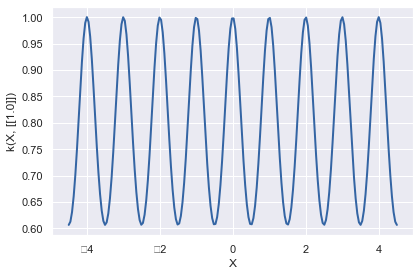

In [122]:
ker.plot()

In [123]:
def plot_model(X, y, kernel):
    model = GPy.models.GPRegression(X, y, kernel)
    model.optimize()
    print(model)
    
    x = np.linspace(1948, 1964, 400).reshape(-1, 1)
    prediction_mean, prediction_var = model.predict(x)
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, '.', label='Train data')
    plt.plot(x, prediction_mean, label='Prediction')
    plt.fill_between(x.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, alpha=0.3)


Name : GP regression
Objective : 670.4420161315217
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   255636.4284232977  |      +ve      |        
  rbf.lengthscale          |   16.62250305279916  |      +ve      |        
  Gaussian_noise.variance  |  1654.4704522055438  |      +ve      |        


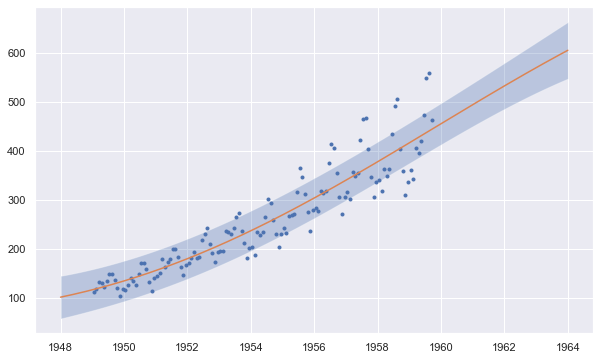

In [124]:
k_rbf = GPy.kern.RBF(1)
plot_model(X, y, k_rbf)

Мы попробуем моделировать данные как 3 аддитивные компоненты: тренд, сезонность и шум.

Поэтому ядро должно быть суммой трёх ядер:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

#### Let's first try to model trend

{'covariance': [[<matplotlib.lines.Line2D at 0x7fb1e42837f0>]]}

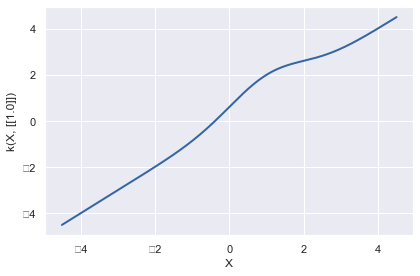

In [127]:
k_trend = GPy.kern.Linear(input_dim=1) + GPy.kern.RBF(input_dim=1)
k_trend.plot()

{'covariance': [[<matplotlib.lines.Line2D at 0x7fb1e41be790>]]}

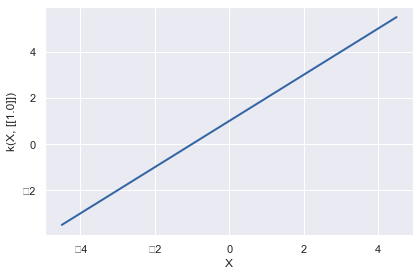


Name : GP regression
Objective : 1377.4206242984894
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  poly.variance            |   0.34644465411921327  |      +ve      |        
  poly.scale               |  0.023762849946810223  |      +ve      |        
  poly.bias                |    0.9997696507389795  |      +ve      |        
  Gaussian_noise.variance  |    0.9999999999979341  |      +ve      |        


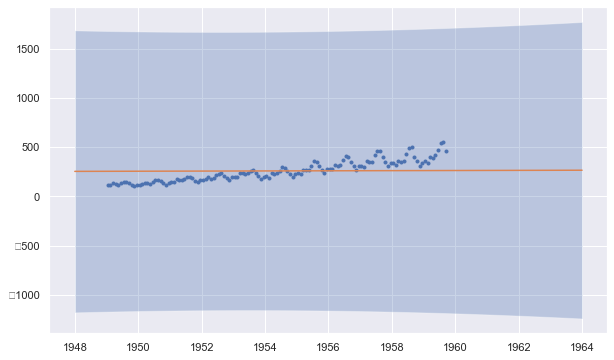

In [134]:
k_trend = GPy.kern.Poly(input_dim=1) #  + GPy.kern.RBF(input_dim=1)
plot_model(X, y, k_trend)

#### Let's model periodicity

In [65]:
k_trend = GPy.kern.Linear(input_dim=1) + GPy.kern.RBF(input_dim=1, lengthscale=1)
periodic_kern = GPy.kern.StdPeriodic(input_dim=1) # GPy.kern.Cosine(input_dim=1)
periodic_kern.fix()

array([0, 1, 2])


Name : GP regression
Objective : 558.8927467877477
Number of Parameters : 10
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.                    |                  value  |  constraints  |  priors
  sum.linear.variances              |   0.027510246121345255  |      +ve      |        
  sum.rbf.variance                  |      11.40174122603466  |      +ve      |        
  sum.rbf.lengthscale               |  4.422878572097085e-10  |      +ve      |        
  sum.mul.std_periodic.variance     |                    1.0  |   +ve fixed   |        
  sum.mul.std_periodic.period       |                    1.0  |   +ve fixed   |        
  sum.mul.std_periodic.lengthscale  |                    1.0  |   +ve fixed   |        
  sum.mul.linear.variances          |    0.08624148095225553  |      +ve      |        
  sum.mul.rbf.variance              |    0.08624144190635957  |      +ve      |        
  sum.mul.rbf.lengthscale           |     3.2293068511750187  |  

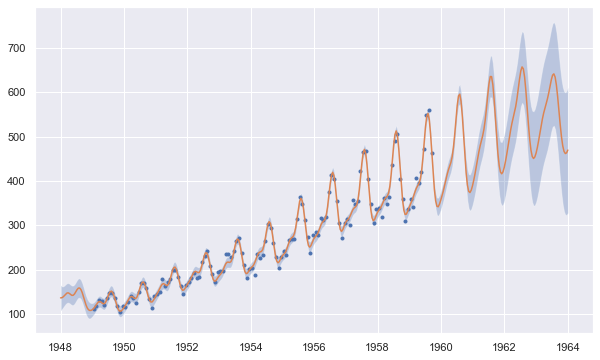

In [68]:
k_seasonal = periodic_kern * GPy.kern.Linear(input_dim=1) * GPy.kern.RBF(1)
kernel = k_trend + k_seasonal
plot_model(X, y, kernel)

Let's add noise model.
`GPy.kern.White()` kernel models noise at training points: $k_{white}(x, x') = \delta(x - x')$


Name : GP regression
Objective : 500.84660305378173
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  GP_regression.                    |                  value  |  constraints  |  priors
  sum.linear.variances              |   0.023543162747892726  |      +ve      |        
  sum.rbf.variance                  |      87.86364492466288  |      +ve      |        
  sum.rbf.lengthscale               |     0.5391172398279414  |      +ve      |        
  sum.mul.std_periodic.variance     |    0.19322253817441268  |      +ve      |        
  sum.mul.std_periodic.period       |     1.0026370604974377  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |     0.4825714492218805  |      +ve      |        
  sum.mul.linear.variances          |    0.19322253919641358  |      +ve      |        
  sum.mul.rbf.variance              |    0.19322253793785563  |      +ve      |        
  sum.mul.rbf.lengthscale           |     10.742855529519439  |

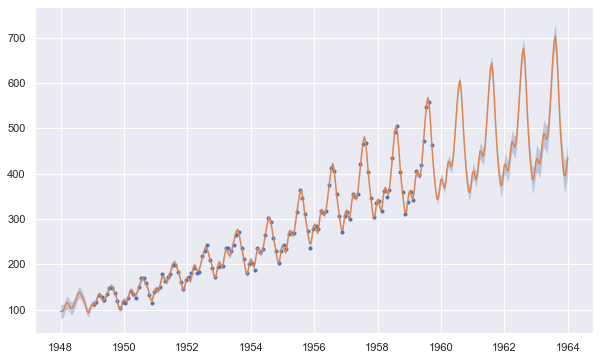

In [71]:
k_trend = GPy.kern.Linear(input_dim=1) + GPy.kern.RBF(1)
k_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1)
k_noise = GPy.kern.White(1) * GPy.kern.Linear(1)
kernel = k_trend + k_periodicity + k_noise

plot_model(X, y, kernel)

# Deep Kernel Learning with GP

```
pip install gpytorch
```

Рассмотрим пару примеров на использование KISS-GP и KISS-GP с Kernel Learning. 

![](kiss.png)

In [72]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [73]:
n = 60
xx, yy = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
train_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# sin( 2 * pi * (x0+x1))
train_y = torch.sin((train_x[:, 0] + train_x[:, 1]) * (4 * math.pi)) + torch.randn_like(train_x[:, 0]).mul(0.01)

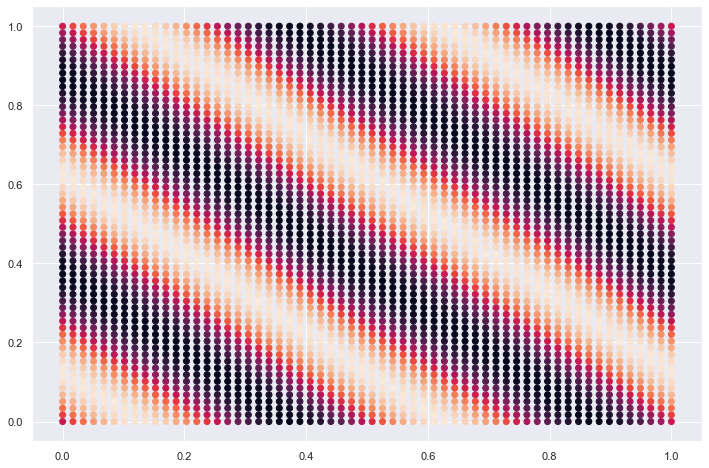

In [74]:
plt.figure(figsize=(12, 8));
plt.scatter(train_x[:, 0], train_x[:, 1], c=train_y);
plt.show();

In [75]:
kernel = gpytorch.kernels.PeriodicKernel()

In [76]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        
        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            gpytorch.kernels.ScaleKernel(
                kernel,
            ), grid_size=grid_size, num_dims=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel)

In [77]:
# оптимизатор нейронки
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

In [78]:
# лосс-функция
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [79]:
def train(training_iterations = 50):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        #for p in list(model.parameters()):
        #    p.grad[p.grad != p.grad] = 0.
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

%time train()

Iter 1/50 - Loss: 1.063
Iter 2/50 - Loss: 1.004
Iter 3/50 - Loss: 0.903
Iter 4/50 - Loss: 0.764
Iter 5/50 - Loss: 0.632
Iter 6/50 - Loss: 0.577
Iter 7/50 - Loss: 0.616
Iter 8/50 - Loss: 0.606
Iter 9/50 - Loss: 0.527
Iter 10/50 - Loss: 0.429
Iter 11/50 - Loss: 0.363
Iter 12/50 - Loss: 0.340
Iter 13/50 - Loss: 0.331
Iter 14/50 - Loss: 0.298
Iter 15/50 - Loss: 0.233
Iter 16/50 - Loss: 0.151
Iter 17/50 - Loss: 0.086
Iter 18/50 - Loss: 0.062
Iter 19/50 - Loss: 0.042
Iter 20/50 - Loss: -0.027
Iter 21/50 - Loss: -0.108
Iter 22/50 - Loss: -0.152
Iter 23/50 - Loss: -0.177
Iter 24/50 - Loss: -0.229
Iter 25/50 - Loss: -0.310
Iter 26/50 - Loss: -0.357
Iter 27/50 - Loss: -0.382
Iter 28/50 - Loss: -0.456
Iter 29/50 - Loss: -0.518
Iter 30/50 - Loss: -0.548
Iter 31/50 - Loss: -0.615
Iter 32/50 - Loss: -0.677
Iter 33/50 - Loss: -0.704
Iter 34/50 - Loss: -0.787
Iter 35/50 - Loss: -0.818
Iter 36/50 - Loss: -0.887
Iter 37/50 - Loss: -0.930
Iter 38/50 - Loss: -0.986
Iter 39/50 - Loss: -1.043
Iter 40/50 - L

In [80]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

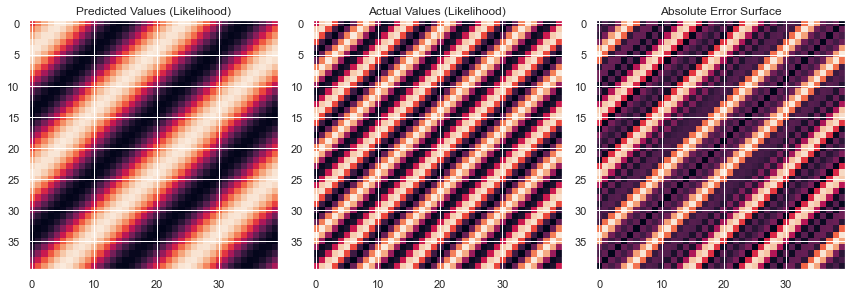

In [81]:
n = 40
xx, yy = np.meshgrid(np.linspace(-1, 2, n), np.linspace(-1, 2, n))
test_x = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)
test_y_actual = torch.sin(((test_x[:, 0] + test_x[:, 1]) * (4 * math.pi))).view(n, n)

with torch.no_grad(), gpytorch.settings.fast_pred_var(): # , gpytorch.fast_pred_var()
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    
# Предсказания
ax[0].imshow(pred_labels)
ax[0].set_title('Predicted Values (Likelihood)')

# Ground truth
ax[1].imshow(test_y_actual)
ax[1].set_title('Actual Values (Likelihood)')

# Ошибки
ax[2].imshow(delta_y)
ax[2].set_title('Absolute Error Surface')

fig.tight_layout()

# Scalabel GP + Deep Learning

Зачем подбирать ядра и мучиться если можно обучить нейросетку?

In [82]:
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor

if not os.path.isfile('elevators.mat'):
    print('Downloading \'elevators\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1jhWL3YUHvXIaftia4qeAyDwVxo6j1alk', 'elevators.mat')
    
data = torch.Tensor(loadmat('elevators.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

train_n = int(floor(0.8*len(X)))

train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

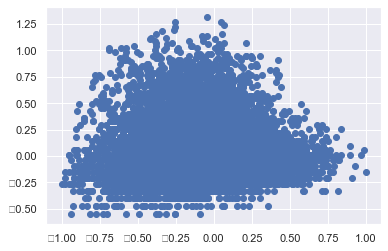

In [86]:
plt.scatter(X[:, 1], y);

In [108]:
data_dim = train_x.size(-1)

class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 128))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(128, 128))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(128, 128))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(128, 2))         
                                                             
feature_extractor = LargeFeatureExtractor()

In [109]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, kernel):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(kernel),
                num_dims=2, grid_size=100
            )
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # пропускаем данные через нейронку
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [110]:
kernel = gpytorch.kernels.RBFKernel(ard_num_dims=2)

In [111]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood, kernel=kernel)

In [112]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [113]:
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.1)

In [114]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [115]:
def train(training_iterations = 50):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        
with gpytorch.settings.use_toeplitz(True):
    %time train()

Iter 1/50 - Loss: 0.774
Iter 2/50 - Loss: 0.736
Iter 3/50 - Loss: 0.692
Iter 4/50 - Loss: 0.652
Iter 5/50 - Loss: 0.611
Iter 6/50 - Loss: 0.570
Iter 7/50 - Loss: 0.528
Iter 8/50 - Loss: 0.486
Iter 9/50 - Loss: 0.442
Iter 10/50 - Loss: 0.405
Iter 11/50 - Loss: 0.360
Iter 12/50 - Loss: 0.320
Iter 13/50 - Loss: 0.275
Iter 14/50 - Loss: 0.228
Iter 15/50 - Loss: 0.186
Iter 16/50 - Loss: 0.140
Iter 17/50 - Loss: 0.095
Iter 18/50 - Loss: 0.050
Iter 19/50 - Loss: 0.004
Iter 20/50 - Loss: -0.039
Iter 21/50 - Loss: -0.086
Iter 22/50 - Loss: -0.132
Iter 23/50 - Loss: -0.175
Iter 24/50 - Loss: -0.222
Iter 25/50 - Loss: -0.265
Iter 26/50 - Loss: -0.309
Iter 27/50 - Loss: -0.353
Iter 28/50 - Loss: -0.397
Iter 29/50 - Loss: -0.438
Iter 30/50 - Loss: -0.481
Iter 31/50 - Loss: -0.519
Iter 32/50 - Loss: -0.561
Iter 33/50 - Loss: -0.597
Iter 34/50 - Loss: -0.633
Iter 35/50 - Loss: -0.672
Iter 36/50 - Loss: -0.699
Iter 37/50 - Loss: -0.725
Iter 38/50 - Loss: -0.770
Iter 39/50 - Loss: -0.790
Iter 40/50 - L

In [116]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

In [117]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 0.08035852760076523


In [105]:
print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))

Test MAE: 0.11645974218845367
